In [24]:
import numpy as np 
from sklearn.linear_model import LinearRegression
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statistics import mode

from scipy import stats
from scipy.stats import norm, normaltest
from scipy import stats 

import pickle

from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, train_test_split 
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVC

from xgboost import XGBRegressor

In [2]:
# import keyboard

# def run():
#     running=True
#     while running:
        
#         for c in data.columns:
#             x = input(f'{c}, {data[c][0:3]} \n')
#             categories_assign.append(x)
#         if keyboard.is_pressed('alt'):
#             break

# run()

In [3]:
data = pd.read_csv("data/train.csv", encoding="utf-8")

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data["Percent"]<0.10]

test = pd.read_csv("data/test.csv", encoding="utf-8")
test = test[missing_data.index.drop('SalePrice')]

categories_assign = pd.read_csv("data/categories_assigned.txt", encoding="utf-8")
categories_assign = categories_assign['type']

data
    

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
data["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

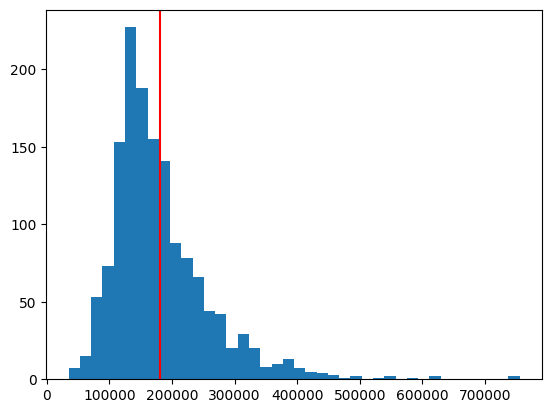

In [5]:
fig, ax = plt.subplots(1,1)
ax.hist(data["SalePrice"], bins = 40)
ax.axvline(180921.195890, color = "red")

C:\Users\wilkk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


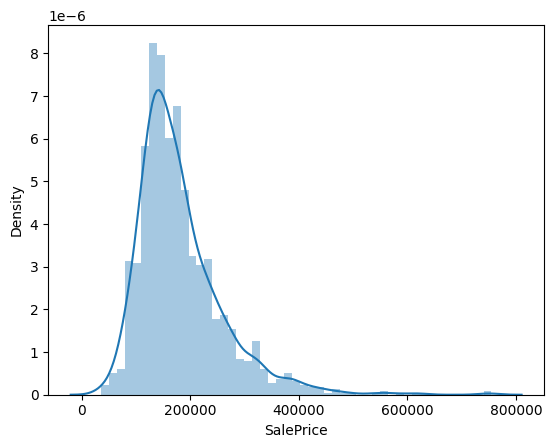

In [6]:
sns.distplot(data['SalePrice']);

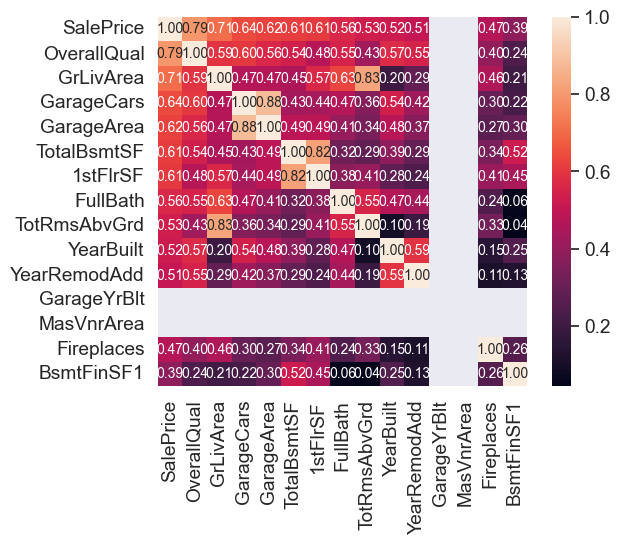

In [7]:
#saleprice correlation matrix
corrmat = data.corr()
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

C:\Users\wilkk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


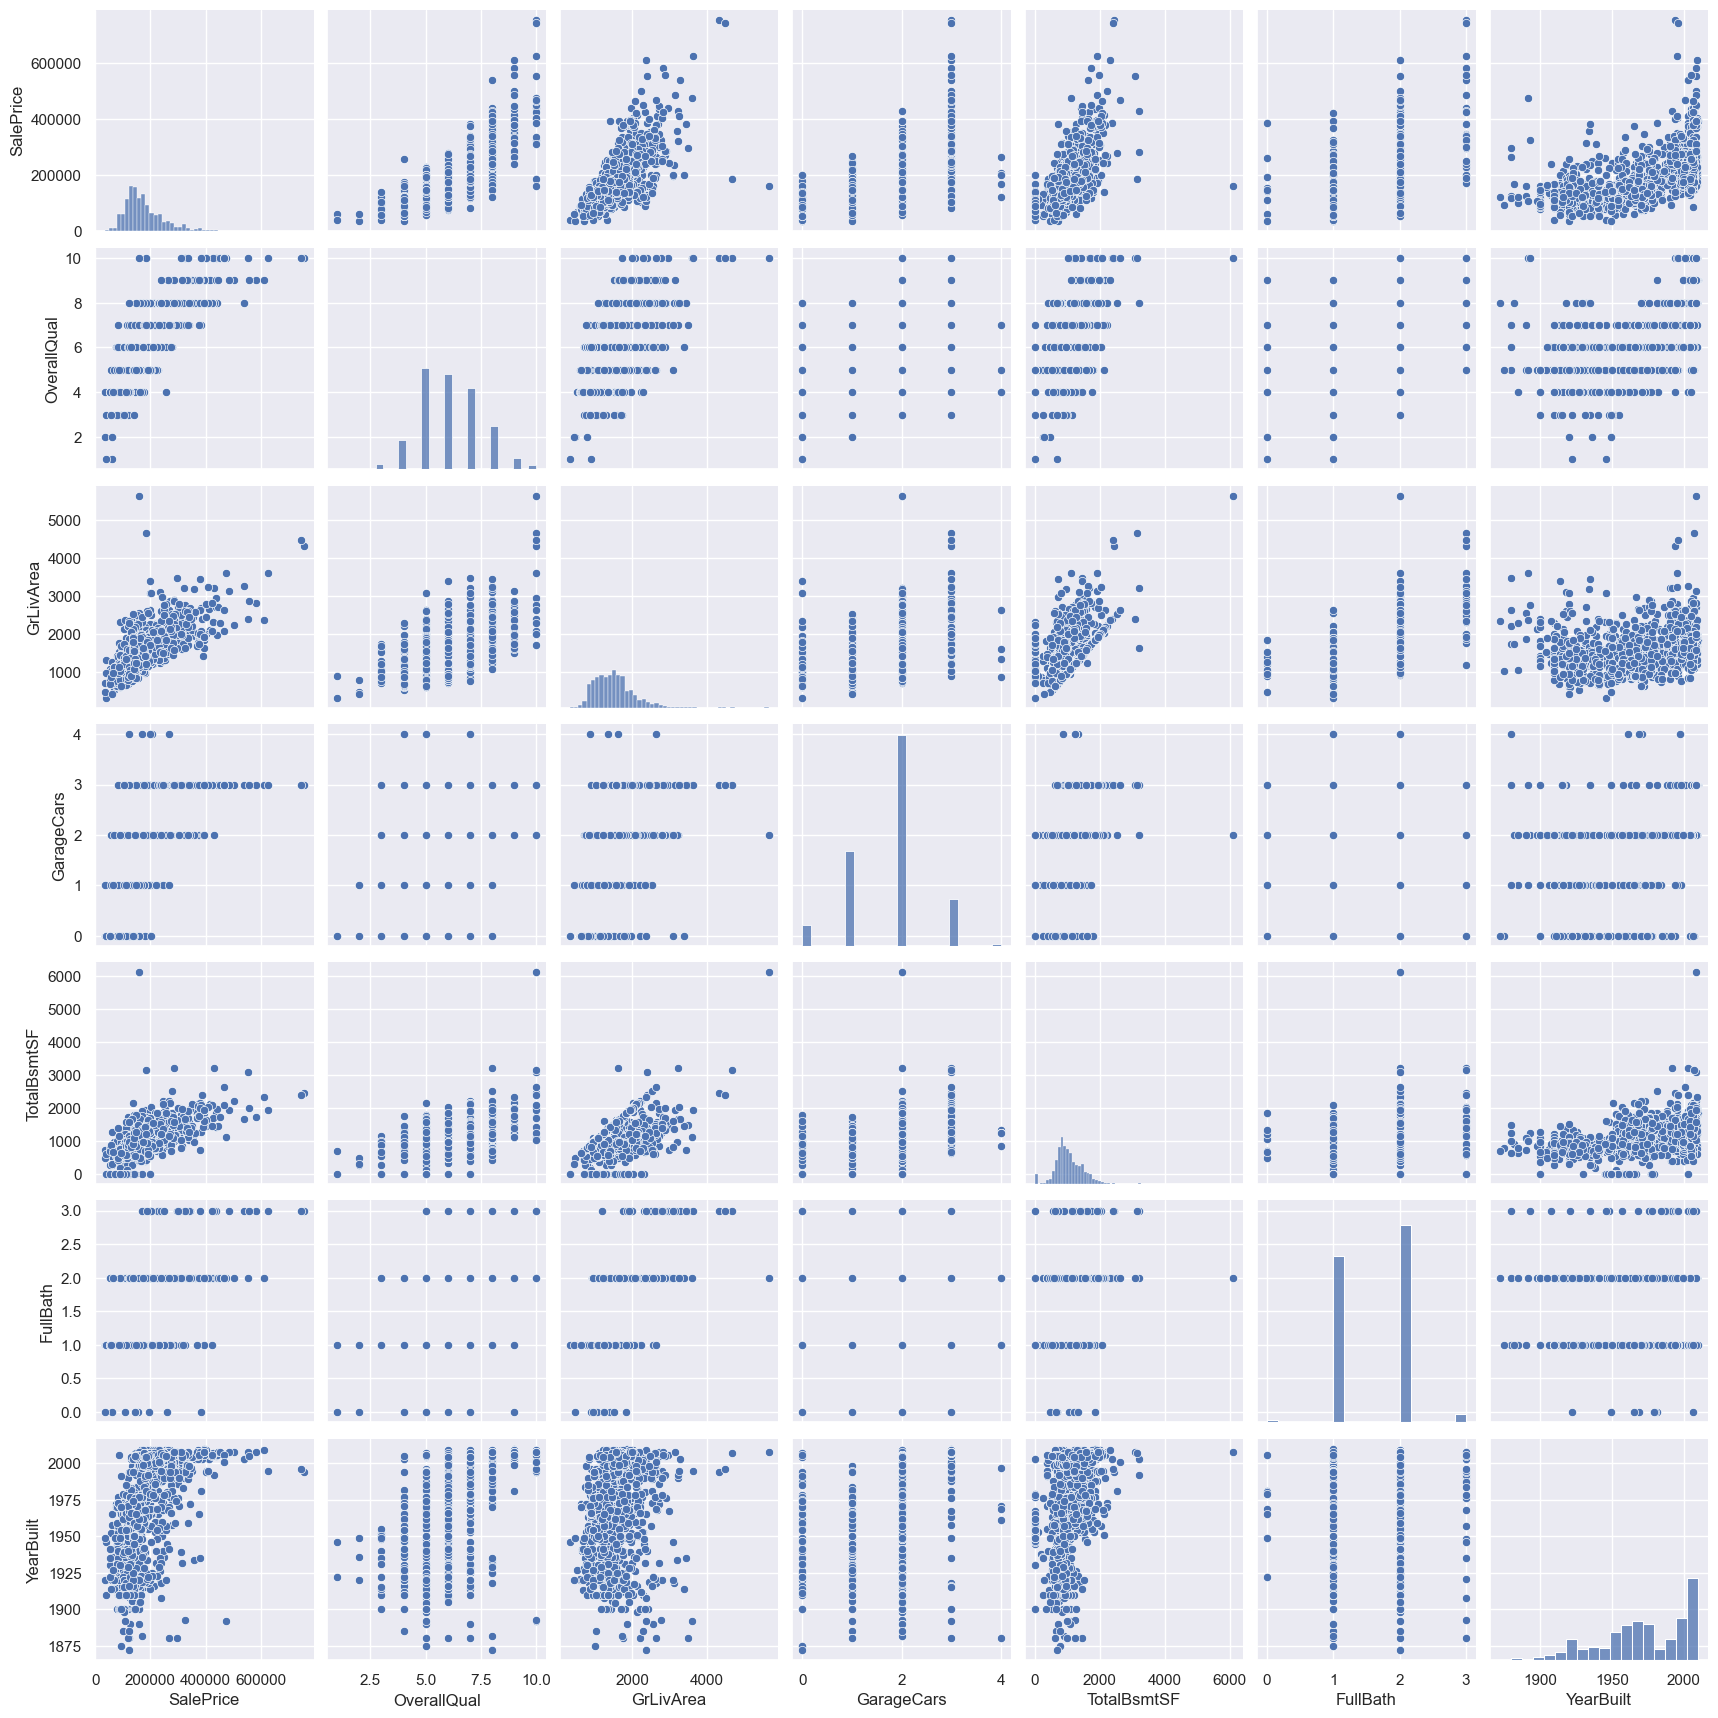

In [8]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data[cols], size = 2.5)
plt.show();

In [9]:
print(data.isnull().sum().max())
print(test.isnull().sum().max())

1453
78


Since we miss some values, lets try to fill out the missing ones. 

In [10]:
def filler (df : pd.DataFrame):
    for c in df.columns:
        if df[c].dtype != object:
            df[c].fillna(np.mean(df[c]), inplace=True)
        else:
            df[c].fillna(mode(df[c].astype(str)), inplace=True)
    return df 


In [11]:
data = filler(data)
test = filler(test)

In [12]:
print(data.isnull().sum().max())
print(test.isnull().sum().max())

0
0


In [13]:

for i,c in enumerate(data.columns):
    data[c].astype(categories_assign[i], copy = False)

for i,c in enumerate(test.columns):
    test[c].astype(data[c].dtypes, copy = False)



Below we looked if the sale price is normally distributed. 

In [14]:
s, p = normaltest(data["SalePrice"])

In [15]:
p < 1e-3

True

H0: Data comes from normal distribution (It is the native assumption in D'Agostino-Pearson Test)

Since p value is smaller than 0.001 we reject our H0. Hence, the data does not come from normal distribution. In other words, Sale prices are not normal. Although, histogram suggests otherwise. 

In [16]:
np.log(2)

0.6931471805599453

I could address that the independent variables are not linear to mitigate heteroscedasticity, but I will try first to work without any data transformations for now and see where it leads me. 

## Search for heteroscedasticity

In [17]:
numeric_vars = []
if len(numeric_vars) == 0:
    for c in data.columns: 
        if type(data[f'{c}'][0]) == np.int64 or type(data[f'{c}'][0]) == np.float64:
            numeric_vars.append(c)
numeric_vars.remove("Id")

In [25]:
# for c in numeric_vars:
#     X = data[c].values.reshape(-1,1)
#     y = data["SalePrice"]

#     ols = LinearRegression()
#     model = ols.fit(X, y)
#     response = model.predict(X)

#     r2 = model.score(X, y)

#     plt.style.use('default')
#     plt.style.use('ggplot')

#     fig, ax = plt.subplots(figsize=(8, 4))

#     ax.plot(X, response, color='k', label='Regression model')
#     ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
#     ax.set_ylabel('Prices', fontsize=14)
#     ax.set_xlabel(f'{c}', fontsize=14)
#     ax.legend(facecolor='white', fontsize=11)
#     ax.set_title('$R^2= %.2f$' % r2, fontsize=18)

#     fig.tight_layout()

In [31]:
def ml_tree(df, dataset: str):
    try:
        grid = pickle.load(open(f'data/processed/{dataset}_grid.dat', 'rb'))
    except:
        kf = KFold(n_splits=6, shuffle=True)
        
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
        )

        categorical_transformer = OneHotEncoder(handle_unknown="ignore")

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, selector(dtype_exclude=["category",'object'])),
                ("cat", categorical_transformer, selector(dtype_include=["category",'object'])),
            ]
        )
        
        columns = df.columns
        columns = columns.drop("SalePrice")
        
        pipeline = Pipeline([('preprocessor',preprocessor),
                            ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
                            ("classifier",DecisionTreeRegressor())])
    
        parameters = {#"classifier__splitter":['squared_error'],
                      "classifier__max_depth": range(1,31,5),
                      "classifier__max_features":["sqrt",'log2','auto'],
                      #"classifier__max_leaf_nodes": range(1,101,5)
                     }
    
        grid = GridSearchCV(pipeline, parameters, scoring='r2', cv=kf, n_jobs=-1)
        grid.fit(df[columns], df["SalePrice"])
    
        pickle.dump(grid, open(f'data/processed/{dataset}_grid.dat', 'wb'))
    finally:
        print(f'Optimal parameters: {grid.best_params_}')
        print(f'best r2: {grid.best_score_}')
        
        return grid

In [27]:
def ml_log(df, dataset: str):
    try:
        grid = pickle.load(open(f'data/processed/{dataset}_grid.dat', 'rb'))
    except:
        kf = KFold(n_splits=6, shuffle=True)
        
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
        )

        categorical_transformer = OneHotEncoder(handle_unknown="ignore")

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, selector(dtype_exclude=["category",'object'])),
                ("cat", categorical_transformer, selector(dtype_include=["category",'object'])),
            ]
        )
        
        columns = df.columns
        columns = columns.drop("SalePrice")
        
        pipeline = Pipeline([('preprocessor',preprocessor),
                            ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
                            ("classifier", LogisticRegression())])
    
        parameters = {"classifier__penalty":['l1','l2','elasticnet','none'],
                      "classifier__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                      "classifier__max_iter":[1000]
                     }
    
        grid = GridSearchCV(pipeline, parameters, scoring='r2', cv=kf, n_jobs=-1)
        grid.fit(df[columns], df["SalePrice"])
    
        pickle.dump(grid, open(f'data/processed/{dataset}_grid.dat', 'wb'))
    finally:
        print(f'Optimal parameters: {grid.best_params_}')
        print(f'best r2: {grid.best_score_}')
        
        return grid

In [28]:
def ml_xgboost(df, dataset: str):
    try:
        grid = pickle.load(open(f'data/processed/{dataset}_grid.dat', 'rb'))
    except:
        kf = KFold(n_splits=6, shuffle=True)
        
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
        )

        categorical_transformer = OneHotEncoder(handle_unknown="ignore")

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, selector(dtype_exclude=["category",'object'])),
                ("cat", categorical_transformer, selector(dtype_include=["category",'object'])),
            ]
        )
        
        columns = df.columns
        columns = columns.drop("SalePrice")
        
        pipeline = Pipeline([('preprocessor',preprocessor),
                            ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
                            ("classifier", XGBRegressor())])
    
        parameters = {  "classifier__n_estimators": [500, 750, 1000, 1500, 2000], 
                        "classifier__learning_rate": [0.01, 0.02, 0.05], 
                        "classifier__max_depth": [6, 8], 
                        "classifier__subsample": [0.3, 0.5, 0.7]
                     }
    
        grid = GridSearchCV(pipeline, parameters, scoring='r2', cv=kf, n_jobs=-1)
        grid.fit(df[columns], df["SalePrice"])
    
        pickle.dump(grid, open(f'data/processed/{dataset}_grid.dat', 'wb'))
    finally:
        print(f'Optimal parameters: {grid.best_params_}')
        print(f'best r2: {grid.best_score_}')
        
        return grid

In [29]:
def ml_nn(df, dataset: str):
    try:
        grid = pickle.load(open(f'data/processed/{dataset}_grid.dat', 'rb'))
    except:
        kf = KFold(n_splits=6, shuffle=True)

        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
        )

        categorical_transformer = OneHotEncoder(handle_unknown="ignore")

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, selector(dtype_exclude=["category",'object'])),
                ("cat", categorical_transformer, selector(dtype_include=["category",'object'])),
            ]
        )
        
        columns = df.columns
        columns = columns.drop("SalePrice")
        
        
        pipeline = Pipeline([('preprocessor',preprocessor),
                            ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
                            ("classifier",MLPRegressor())])
    
        parameters = {"classifier__learning_rate":['constant', 'invscaling', 'adaptive'],
                      "classifier__alpha": 10.0 ** -np.arange(1, 7),
                      "classifier__activation":['identity', 'logistic', 'tanh', 'relu']
                     }
    
        grid = GridSearchCV(pipeline, parameters, scoring='r2', cv=kf, n_jobs=-1)
        grid.fit(df[columns], df["SalePrice"])
    
        pickle.dump(grid, open(f'data/processed/{dataset}_grid.dat', 'wb'))
    finally:
        print(f'Optimal parameters: {grid.best_params_}')
        print(f'best r2: {grid.best_score_}')
        
        return grid

In [32]:
grid_tree = ml_tree(data,"tree")

Optimal parameters: {'classifier__max_depth': 6, 'classifier__max_features': 'auto'}
best r2: 0.7460432059928546


C:\Users\wilkk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\wilkk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


In [33]:
grid_log = ml_log(data,"log")

C:\Users\wilkk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
54 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wilkk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wilkk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pack

Optimal parameters: {'classifier__max_iter': 1000, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}
best r2: 0.6510986448997418


C:\Users\wilkk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [34]:
grid_xgboost = ml_xgboost(data,"xgboost")

C:\Users\wilkk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Optimal parameters: {'classifier__learning_rate': 0.02, 'classifier__max_depth': 6, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.7}
best r2: 0.8769192159863651


In [35]:
results = grid_tree.predict(test)
res = test["Id"]
res = pd.DataFrame(res)
res["SalePrice"] = results
res.to_csv('data/solutions/tree.res',index=False)

KeyError: "['LotFrontage'] not in index"

Might add a part of feature engeenering. I nice idea I found was to combine all living area, total ground area and total basement area. It seems reasonble since we often look at the size of living area when looking for a new house. However, I am not sure, why this metric would boost anything, but yet it might be worth a shot. 

In addition, I could have handled missing data better. For instance, fill out the missing numercical values with averages for each column and the median for the categorical data. 

Now, lets experiment with stacking. 